In [1]:
from sympy import *
import numpy as np
import math

import matplotlib.pyplot as plt

# The Rayleigh equation and the Shear Layer instability

Some of the reasoning is based on Criminale, Jackson, Joslin THEORY AND COMPUTATION OF HYDRODYNAMIC STABILITY, 2003

We will attempt to solve the stability problem of an inviscid shear layer using the Rayleigh equations

The Orr-Sommerfeld equation (4'th order for v)
$$
(U-c)(\frac{\partial^2 v}{\partial y^2}-\alpha^2 v) - \frac{\partial^2 U}{\partial y} v =
(i \alpha Re)^{-1}(\frac{\partial^4 v}{\partial y^4}-2\alpha^2 \frac{\partial^2 v}{\partial y^2} + \alpha^4 v)
$$
has a problem in the fact that it is the forth order and not so much fun to solve. But in the limit of $Re\to\infty$ it gets to be much nicer. The Rayleigh equation is than:
$$
(U-c)(\frac{\partial^2 v}{\partial y^2}-\alpha^2 v) - \frac{\partial^2 U}{\partial y} v = 0
$$
In the above $c$ is a complex wave velocity while $\omega=\alpha c$ the complex wave length, and $\alpha$ plays a role of a real wavenumber defining the spatial extension of the perturbation.

Let us start with piecewise linear profile (this way we will be able to obtain necessary constants). That is let the velocity $U$ be as follows:

$$
U(y) = tanh(y)
$$
It is good to start with a plot:

In [2]:
y = Symbol('y')
U = tanh(y)
dU = U.diff(y)
ddU= dU.diff(y)

In [3]:
print(U)
print(dU)
print(ddU)

tanh(y)
1 - tanh(y)**2
-(2 - 2*tanh(y)**2)*tanh(y)


In [4]:
fU = lambdify(y, U, 'numpy')
fdU= lambdify(y, dU, 'numpy')
fddU= lambdify(y, ddU, 'numpy')

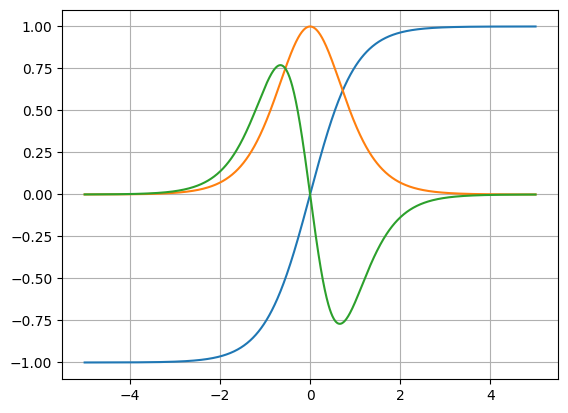

In [5]:
Y = np.linspace(-5,5,1000)
plt.plot(Y,fU(Y))
plt.plot(Y,fdU(Y))
plt.plot(Y,fddU(Y))
plt.grid()

Let us have a look at our problem (with a pen and paper) and try to show it as general eigenvalue problem:
$$
Av = cBv
$$

After some simple manipulations we should get:

$$
(U\frac{\partial^2}{\partial y^2}-\alpha^2U-\frac{\partial^2U}{\partial y^2})v = 
c(\frac{\partial^2}{\partial y^2}-\alpha^2)v
$$
which we could solve, or apply discretization to arrive at an algebraic problem. Let's use the simples finite differences. We have analitic formulas for $U$ and its derivatives, so the only part that needs treatment is $v$. Let's assume equidistant FD grid and use the second order formula for second derivative:
$$
\frac{\partial^2 f}{\partial x^2} = \frac{f_{i+1} - 2f_{i} + f_{i-1}}{h^2}
$$

We will need some libraries for this work

In [6]:
from scipy.sparse import diags
from scipy.linalg import eigh, eig
import numpy as np

In [7]:
n = 100
Y = np.linspace(-10,10,n) # the mesh
h = Y[1] - Y[0]

In [8]:
def AssembleSystem(alpha):
    # Matrices A and B
    a = [np.zeros(n-1), np.zeros(n), np.zeros(n-1)]
    b = [np.zeros(n-1), np.zeros(n), np.zeros(n-1)]
    for i in range(0,n): # inner system
        ui   = fU(Y[i])
        uyyi = fddU(Y[i])
        a[1][i] = -2 * ui / h**2 - alpha**2 * ui - uyyi
        b[1][i] = -2 / h**2 - alpha**2
    for i in range(1,n): # lower
        ui   = fU(Y[i])
        a[0][i-1] = ui / h**2 
        b[0][i-1] = 1/h**2
    for i in range(0,n-1): # upper
        ui   = fU(Y[i])
        a[2][i] = ui / h**2
        b[2][i] = 1/h**2
    

    offset = [-1,0,1]
    A = diags(a,offset).toarray()
    B = -diags(b,offset).toarray()
    return A, B

In [9]:
for a in np.linspace(0,1):
    A, B = AssembleSystem(alpha=a)
    eigvals, eigvecs = eig(A, B)

In [10]:
eigvals[0]

(-0.19470407027189204+0j)

In [11]:
eigvecs[0]

array([ 6.70643624e-06+0.00000000e+00j,  9.67512312e-06-1.74617739e-07j,
        9.67512312e-06+1.74617739e-07j,  1.33026086e-05+0.00000000e+00j,
        4.45466944e-06+0.00000000e+00j,  1.75061590e-05+0.00000000e+00j,
       -2.87610767e-06+0.00000000e+00j, -2.23096251e-05+0.00000000e+00j,
       -1.82859357e-06+0.00000000e+00j, -2.78754181e-05+0.00000000e+00j,
        1.15523000e-06+0.00000000e+00j, -3.44550149e-05+0.00000000e+00j,
        7.28849003e-07+0.00000000e+00j, -4.23541369e-05+0.00000000e+00j,
        4.60298617e-07+0.00000000e+00j, -5.19262646e-05+0.00000000e+00j,
        2.91235338e-07+0.00000000e+00j, -6.35836032e-05+0.00000000e+00j,
        1.84630238e-07+0.00000000e+00j, -7.78156370e-05+0.00000000e+00j,
        1.17255007e-07+0.00000000e+00j, -9.52115833e-05+0.00000000e+00j,
        7.45761613e-08+0.00000000e+00j, -1.16486408e-04+0.00000000e+00j,
        4.74871994e-08+0.00000000e+00j, -1.42511334e-04+0.00000000e+00j,
        3.02652433e-08+0.00000000e+00j, -1.74350240

/home/sgepner/Virtualenv/jupyter/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


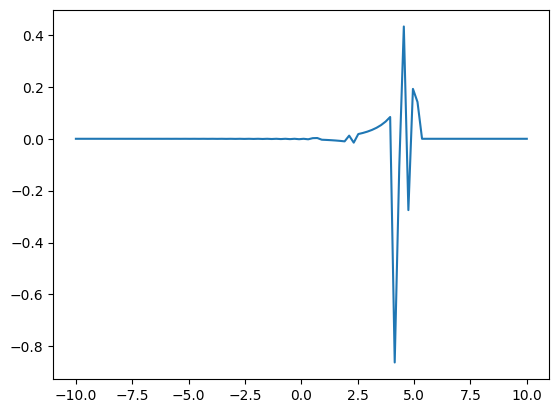

In [12]:
plt.plot(Y, eigvecs[0])